# SMK-CAN-187 Datasets

In [25]:
from scipy.io import loadmat
data_mat = loadmat('SMK-CAN-187.mat')
data_X = data_mat['X']
data_y = data_mat['Y']
data_y = data_y.flatten()
print(data_X.shape, data_y.shape)

(187, 19993) (187,)


In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_X = scaler.fit_transform(data_X)

In [27]:
import numpy as np 
data_y[np.where(data_y==1)] = 0
data_y[np.where(data_y==2)] = 1

## No Feature Selection

In [28]:
from torch import nn
import torch
def make_models(input_dims):
    models = []
    for input_dim in input_dims:
        model = []
        if input_dim >= 512:
            model.append(nn.Linear(input_dim, 512))
            model.append(nn.ReLU())
            model = model + [nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU()]
        else:
            model = [nn.Linear(input_dim, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU()]
        models.append(nn.Sequential(*model))
    top_model = nn.Sequential(
        nn.Linear(len(input_dims)*128, 32), nn.ReLU(True), nn.Linear(32, 1), nn.Sigmoid()
    )
    return models, top_model

In [29]:
import torch 
from Courier import SyncLocalCourier
from VFLDataUtils import SimpleNumpyDataLoader
from Client import SyncFNNClient
from Strategy import SyncConcatStrategy
from Server import SyncFNNServer
torch.manual_seed(0)
EMB_DIM = 128
baselines_no_fs = {}
for client_num in range(1, 6):
    client_id_list = list(range(client_num))
    courier = SyncLocalCourier(client_id_list)
    loader = SimpleNumpyDataLoader(
        clients_id_list=client_id_list,
        data_source=(data_X, data_y)
    )
    loader_dict, input_dims = loader.distribute()
    models, top_model = make_models(input_dims)
    # for model in models: print(model)
    # print(top_model)
    clients = []
    for i, id in enumerate(client_id_list):
        client = SyncFNNClient(
            id=id,
            model= models[i],
            courier=courier,
            train_loader=loader_dict[id]['train_loader'],
            test_loader=loader_dict[id]['test_loader'],
            config_dir='simple_config.ini')
        clients.append(client)
    strategy = SyncConcatStrategy(courier=courier, clients=clients)
    server = SyncFNNServer(
        strategy=strategy,
        courier=courier,
        top_model=top_model,
        emb_model=models[-1],
        train_loader=loader_dict['server']['train_loader'],
        test_loader=loader_dict['server']['test_loader'],
        config_dir='simple_config.ini')
    
    print('Training Starts')
    print(f'Number of Clients: {client_num}')
    print('-'*89)
    for epoch in range(100):
        server.fit(epoch)
    history = server.get_history()
    baselines_no_fs[client_num] = history    
    
    


Client 0: Feature Index 0-9996
Server : Feature Index 9997-19992
Training Starts
Number of Clients: 1
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.69975 | Acc: 0.421 | Val ACC: 0.526
Epoch 001: | Loss: 0.69245 | Acc: 0.579 | Val ACC: 0.526
Epoch 002: | Loss: 0.69092 | Acc: 0.579 | Val ACC: 0.526
Epoch 003: | Loss: 0.67989 | Acc: 0.579 | Val ACC: 0.526
Epoch 004: | Loss: 0.66965 | Acc: 0.579 | Val ACC: 0.526
Epoch 005: | Loss: 0.66376 | Acc: 0.579 | Val ACC: 0.526
Epoch 006: | Loss: 0.65902 | Acc: 0.603 | Val ACC: 0.526
Epoch 007: | Loss: 0.65066 | Acc: 0.579 | Val ACC: 0.474
Epoch 008: | Loss: 0.63884 | Acc: 0.607 | Val ACC: 0.447
Epoch 009: | Loss: 0.62451 | Acc: 0.635 | Val ACC: 0.474
Epoch 010: | Loss: 0.61550 | Acc: 0.643 | Val ACC: 0.553
Epoch 011: | Loss: 0.60368 | Acc: 0.619 | Val ACC: 0.632
Epoch 012: | Loss: 0.58882 | Acc: 0.631 | Val ACC: 0.658
Epoch 013: | Loss: 0.57621 | Acc: 0.678 | Val ACC: 0.684
Epoch 014:

In [ ]:
import matplotlib.pyplot as plt
for key, value in baselines_no_fs.items():
    x = np.arange(100)
    y = value['test-acc']
    plt.plot(
        x, y, 
        label=f'{key} clients'
    )
plt.legend()
plt.xlabel('epochs')
plt.ylabel('testing accuracy')
plt.show()


## GINI-method

In [31]:
from Gini import gini_score_fast_old
gini_score = gini_score_fast_old(
    torch.tensor(data_X), torch.tensor(data_y).to(int)
)
indices = torch.argsort(gini_score)[: int(gini_score.shape[0]/2)]
data_X_filterd = data_X[:, indices]
baselines_fs_prior_half= {}
for client_num in range(1, 6):
    client_id_list = list(range(client_num))
    courier = SyncLocalCourier(client_id_list)
    loader = SimpleNumpyDataLoader(
        clients_id_list=client_id_list,
        data_source=(data_X_filterd, data_y)
    )
    loader_dict, input_dims = loader.distribute()
    models, top_model = make_models(input_dims)
    # for model in models: print(model)
    # print(top_model)
    clients = []
    for i, id in enumerate(client_id_list):
        client = SyncFNNClient(
            id=id,
            model= models[i],
            courier=courier,
            train_loader=loader_dict[id]['train_loader'],
            test_loader=loader_dict[id]['test_loader'],
            config_dir='simple_config.ini')
        clients.append(client)
    strategy = SyncConcatStrategy(courier=courier, clients=clients)
    server = SyncFNNServer(
        strategy=strategy,
        courier=courier,
        top_model=top_model,
        emb_model=models[-1],
        train_loader=loader_dict['server']['train_loader'],
        test_loader=loader_dict['server']['test_loader'],
        config_dir='simple_config.ini')
    
    print('Training Starts')
    print(f'Number of Clients: {client_num}')
    print('-'*89)
    for epoch in range(100):
        server.fit(epoch)
    history = server.get_history()
    baselines_fs_prior_half[client_num] = history    

Client 0: Feature Index 0-4997
Server : Feature Index 4998-9995
Training Starts
Number of Clients: 1
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.69537 | Acc: 0.421 | Val ACC: 0.526
Epoch 001: | Loss: 0.68261 | Acc: 0.579 | Val ACC: 0.526
Epoch 002: | Loss: 0.67881 | Acc: 0.579 | Val ACC: 0.526
Epoch 003: | Loss: 0.68109 | Acc: 0.579 | Val ACC: 0.526
Epoch 004: | Loss: 0.67644 | Acc: 0.579 | Val ACC: 0.526
Epoch 005: | Loss: 0.67131 | Acc: 0.579 | Val ACC: 0.526
Epoch 006: | Loss: 0.66185 | Acc: 0.579 | Val ACC: 0.526
Epoch 007: | Loss: 0.65606 | Acc: 0.579 | Val ACC: 0.526
Epoch 008: | Loss: 0.65152 | Acc: 0.603 | Val ACC: 0.526
Epoch 009: | Loss: 0.64403 | Acc: 0.603 | Val ACC: 0.526
Epoch 010: | Loss: 0.63294 | Acc: 0.587 | Val ACC: 0.526
Epoch 011: | Loss: 0.62525 | Acc: 0.635 | Val ACC: 0.474
Epoch 012: | Loss: 0.61759 | Acc: 0.650 | Val ACC: 0.500
Epoch 013: | Loss: 0.60567 | Acc: 0.702 | Val ACC: 0.526
Epoch 014: 

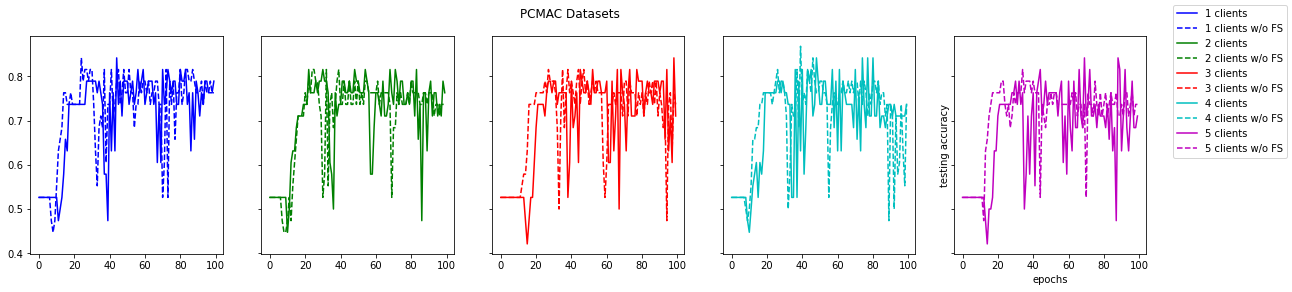

In [32]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1 , 5, figsize=(20, 4), sharey=True)
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i, (key, value) in enumerate(baselines_fs_prior_half.items()):
    x = np.arange(100)
    y = value['test-acc']
    axs[i].plot(
        x, y, 
        label=f'{key} clients', color=colors[i]
    )
    y_no_fs = baselines_no_fs[key]['test-acc']
    axs[i].plot(
        x, y_no_fs, '--',
        label=f'{key} clients w/o FS', color=colors[i]
    )

fig.legend()
plt.xlabel('epochs')
plt.ylabel('testing accuracy')
fig.suptitle('PCMAC Datasets')
# plt.suptitle('PCMAC Datasets')
plt.show()

---

# PCMAC Datasets

In [36]:
from scipy.io import loadmat
data_mat = loadmat('PCMAC.mat')
data_X = data_mat['X']
data_X = data_X.todense()
data_y = data_mat['Y']
data_y = data_y.flatten()
scaler = MinMaxScaler()
data_X = scaler.fit_transform(data_X)
print(data_X.shape, data_y.shape)

(1943, 3289) (1943,)


/home/lianran/miniconda3/envs/phy-env/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/lianran/miniconda3/envs/phy-env/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [37]:
data_y[np.where(data_y==1)] = 0
data_y[np.where(data_y==2)] = 1

In [38]:
torch.manual_seed(0)
EMB_DIM = 128
baselines_no_fs = {}
for client_num in range(1, 6):
    client_id_list = list(range(client_num))
    courier = SyncLocalCourier(client_id_list)
    loader = SimpleNumpyDataLoader(
        clients_id_list=client_id_list,
        data_source=(data_X, data_y)
    )
    loader_dict, input_dims = loader.distribute()
    models, top_model = make_models(input_dims)
    # for model in models: print(model)
    # print(top_model)
    clients = []
    for i, id in enumerate(client_id_list):
        client = SyncFNNClient(
            id=id,
            model= models[i],
            courier=courier,
            train_loader=loader_dict[id]['train_loader'],
            test_loader=loader_dict[id]['test_loader'],
            config_dir='simple_config.ini')
        clients.append(client)
    strategy = SyncConcatStrategy(courier=courier, clients=clients)
    server = SyncFNNServer(
        strategy=strategy,
        courier=courier,
        top_model=top_model,
        emb_model=models[-1],
        train_loader=loader_dict['server']['train_loader'],
        test_loader=loader_dict['server']['test_loader'],
        config_dir='simple_config.ini')
    
    print('Training Starts')
    print(f'Number of Clients: {client_num}')
    print('-'*89)
    for epoch in range(100):
        server.fit(epoch)
    history = server.get_history()
    baselines_no_fs[client_num] = history    
    

Client 0: Feature Index 0-1644
Server : Feature Index 1645-3288
Training Starts
Number of Clients: 1
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.69089 | Acc: 0.559 | Val ACC: 0.674
Epoch 001: | Loss: 0.57164 | Acc: 0.789 | Val ACC: 0.835
Epoch 002: | Loss: 0.32689 | Acc: 0.927 | Val ACC: 0.859
Epoch 003: | Loss: 0.10587 | Acc: 0.972 | Val ACC: 0.869
Epoch 004: | Loss: 0.04585 | Acc: 0.986 | Val ACC: 0.866
Epoch 005: | Loss: 0.03230 | Acc: 0.992 | Val ACC: 0.789
Epoch 006: | Loss: 0.07648 | Acc: 0.969 | Val ACC: 0.856
Epoch 007: | Loss: 0.07629 | Acc: 0.977 | Val ACC: 0.856
Epoch 008: | Loss: 0.03361 | Acc: 0.990 | Val ACC: 0.848
Epoch 009: | Loss: 0.01309 | Acc: 0.998 | Val ACC: 0.859
Epoch 010: | Loss: 0.00813 | Acc: 0.999 | Val ACC: 0.856
Epoch 011: | Loss: 0.00489 | Acc: 0.999 | Val ACC: 0.856
Epoch 012: | Loss: 0.00432 | Acc: 0.999 | Val ACC: 0.859
Epoch 013: | Loss: 0.00421 | Acc: 0.999 | Val ACC: 0.859
Epoch 014: 

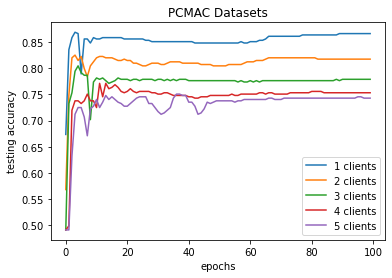

In [39]:
import matplotlib.pyplot as plt
for key, value in baselines_no_fs.items():
    x = np.arange(100)
    y = value['test-acc']
    plt.plot(
        x, y, 
        label=f'{key} clients'
    )
plt.legend()
plt.xlabel('epochs')
plt.ylabel('testing accuracy')
plt.title('PCMAC Datasets')
plt.show()


## Gini method


In [23]:
from Gini import gini_score_fast_old
gini_score = gini_score_fast_old(
    torch.tensor(data_X), torch.tensor(data_y).to(int)
)
indices = torch.argsort(gini_score)[: int(gini_score.shape[0]/2)]
data_X_filterd = data_X[:, indices]
baselines_fs_prior_half= {}
for client_num in range(1, 6):
    client_id_list = list(range(client_num))
    courier = SyncLocalCourier(client_id_list)
    loader = SimpleNumpyDataLoader(
        clients_id_list=client_id_list,
        data_source=(data_X_filterd, data_y)
    )
    loader_dict, input_dims = loader.distribute()
    models, top_model = make_models(input_dims)
    # for model in models: print(model)
    # print(top_model)
    clients = []
    for i, id in enumerate(client_id_list):
        client = SyncFNNClient(
            id=id,
            model= models[i],
            courier=courier,
            train_loader=loader_dict[id]['train_loader'],
            test_loader=loader_dict[id]['test_loader'],
            config_dir='simple_config.ini')
        clients.append(client)
    strategy = SyncConcatStrategy(courier=courier, clients=clients)
    server = SyncFNNServer(
        strategy=strategy,
        courier=courier,
        top_model=top_model,
        emb_model=models[-1],
        train_loader=loader_dict['server']['train_loader'],
        test_loader=loader_dict['server']['test_loader'],
        config_dir='simple_config.ini')
    
    print('Training Starts')
    print(f'Number of Clients: {client_num}')
    print('-'*89)
    for epoch in range(100):
        server.fit(epoch)
    history = server.get_history()
    baselines_fs_prior_half[client_num] = history    

Client 0: Feature Index 0-821
Server : Feature Index 822-1643
Training Starts
Number of Clients: 1
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.68727 | Acc: 0.541 | Val ACC: 0.769
Epoch 001: | Loss: 0.58490 | Acc: 0.794 | Val ACC: 0.794
Epoch 002: | Loss: 0.32201 | Acc: 0.877 | Val ACC: 0.792
Epoch 003: | Loss: 0.17067 | Acc: 0.924 | Val ACC: 0.789
Epoch 004: | Loss: 0.12556 | Acc: 0.952 | Val ACC: 0.794
Epoch 005: | Loss: 0.15049 | Acc: 0.934 | Val ACC: 0.789
Epoch 006: | Loss: 0.17241 | Acc: 0.926 | Val ACC: 0.781
Epoch 007: | Loss: 0.12901 | Acc: 0.954 | Val ACC: 0.807
Epoch 008: | Loss: 0.06097 | Acc: 0.981 | Val ACC: 0.812
Epoch 009: | Loss: 0.04162 | Acc: 0.984 | Val ACC: 0.810
Epoch 010: | Loss: 0.02966 | Acc: 0.990 | Val ACC: 0.805
Epoch 011: | Loss: 0.02352 | Acc: 0.989 | Val ACC: 0.802
Epoch 012: | Loss: 0.02008 | Acc: 0.990 | Val ACC: 0.802
Epoch 013: | Loss: 0.01780 | Acc: 0.992 | Val ACC: 0.805
Epoch 014: | 

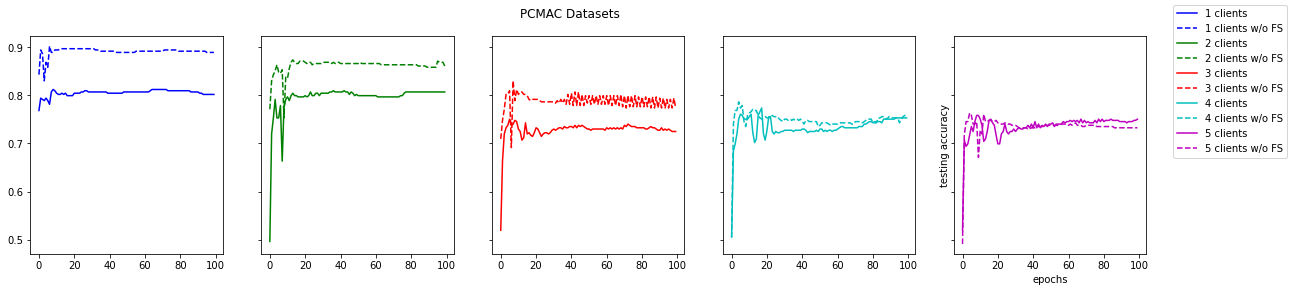

In [27]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1 , 5, figsize=(20, 4), sharey=True)
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i, (key, value) in enumerate(baselines_fs_prior_half.items()):
    x = np.arange(100)
    y = value['test-acc']
    axs[i].plot(
        x, y, 
        label=f'{key} clients', color=colors[i]
    )
    y_no_fs = baselines_no_fs[key]['test-acc']
    axs[i].plot(
        x, y_no_fs, '--',
        label=f'{key} clients w/o FS', color=colors[i]
    )

fig.legend()
plt.xlabel('epochs')
plt.ylabel('testing accuracy')
fig.suptitle('PCMAC Datasets')
# plt.suptitle('PCMAC Datasets')
plt.show()

## STG

In [41]:
from Model import STGEmbModel, make_stg_models
import torch
torch.manual_seed(0)
EMB_DIM = 128
baselines_stg = {}
for client_num in range(1, 6):
    client_id_list = list(range(client_num))
    courier = SyncLocalCourier(client_id_list)
    loader = SimpleNumpyDataLoader(
        clients_id_list=client_id_list,
        data_source=(data_X, data_y)
    )
    loader_dict, input_dims = loader.distribute()
    models, top_model = make_stg_models(input_dims)
    # for model in models: print(model)
    # print(top_model)
    clients = []
    for i, id in enumerate(client_id_list):
        client = SyncFNNClient(
            id=id,
            model= models[i],
            courier=courier,
            train_loader=loader_dict[id]['train_loader'],
            test_loader=loader_dict[id]['test_loader'],
            config_dir='simple_config.ini')
        clients.append(client)
    strategy = SyncConcatStrategy(courier=courier, clients=clients)
    server = SyncFNNServer(
        strategy=strategy,
        courier=courier,
        top_model=top_model,
        emb_model=models[-1],
        train_loader=loader_dict['server']['train_loader'],
        test_loader=loader_dict['server']['test_loader'],
        config_dir='simple_config.ini')
    
    print('Training Starts')
    print(f'Number of Clients: {client_num}')
    print('-'*89)
    for epoch in range(100):
        server.fit(epoch)
        # count number of parameters 
        with torch.no_grad():
            feat_nums = []
            for client in clients:
                # feat_num = client.model.count_num_features()
                # feat_nums.append(feat_num)
                mu = client.model.get_mu()
            total_feat_num = sum(feat_nums)
            print(f'At Epoch {epoch}, {feat_num} features left')      
    history = server.get_history()
    baselines_stg[client_num] = history  

Client 0: Feature Index 0-1644
Server : Feature Index 1645-3288
Training Starts
Number of Clients: 1
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.69324 | Acc: 0.497 | Val ACC: 0.491
At Epoch 0, 1645 features left
Epoch 001: | Loss: 0.62475 | Acc: 0.808 | Val ACC: 0.733
At Epoch 1, 1645 features left
Epoch 002: | Loss: 0.32155 | Acc: 0.883 | Val ACC: 0.838
At Epoch 2, 1645 features left
Epoch 003: | Loss: 0.12070 | Acc: 0.951 | Val ACC: 0.861
At Epoch 3, 1645 features left
Epoch 004: | Loss: 0.05864 | Acc: 0.981 | Val ACC: 0.810
At Epoch 4, 1645 features left
Epoch 005: | Loss: 0.10473 | Acc: 0.959 | Val ACC: 0.846
At Epoch 5, 1645 features left
Epoch 006: | Loss: 0.06806 | Acc: 0.971 | Val ACC: 0.859
At Epoch 6, 1645 features left
Epoch 007: | Loss: 0.02713 | Acc: 0.995 | Val ACC: 0.851
At Epoch 7, 1645 features left
Epoch 008: | Loss: 0.01317 | Acc: 0.998 | Val ACC: 0.846
At Epoch 8, 1645 features left
Epoch 009: | Loss

KeyboardInterrupt: 